<a href="https://colab.research.google.com/github/BeatrizDU/random-walks-MCAP/blob/development/TI_1_Practica2_Beatriz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2

**Nombre:** Beatriz Domínguez Urías

**e-mail:** beatriz.dominguez0182@alumnos.udg.mx

## MODULES

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from scipy.stats import levy_stable
from scipy.stats import wrapcauchy

## CLASSES

In [2]:
class PlotUtility:
  """Class to simplify creation of plots with plotly graph objects module
  """
  def __init__(self, plot_title: str, marker_size=2, line_size=2):
    self.plot_title = plot_title
    self.marker_size = marker_size
    self.line_size = line_size
    self.figure = go.Figure()

  def scatter_plot(self, plot_name: str, x, y, z=None):
    if z is not None:
      self.figure.add_trace(go.Scatter3d(x = list(x),
                                         y = list(y),
                                         z = list(z),
                                         marker = dict(size=self.marker_size),
                                         line = dict(width=self.line_size),
                                         mode = "lines",
                                         name = plot_name,
                                         showlegend = True))
    else:
      self.figure.add_trace(go.Scatter(x = list(x),
                                       y = list(y),
                                       marker = dict(size=self.marker_size),
                                       line = dict(width=self.line_size),
                                       mode = "lines",
                                       name = plot_name,
                                       showlegend = True))

  def show_plot(self, xlabel:str=None, ylabel:str=None, zlabel:str=None):
    self.figure.update_layout(title = self.plot_title,
                              scene = dict(xaxis = dict(title= xlabel),
                                           yaxis = dict(title= ylabel),
                                           zaxis = dict(title= zlabel)))
    self.figure.show()


################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## Actividad 1: Lévy distribution - N Curves (3 pts)

* Generar al menos las 4 curvas de distribución timpo Lévy stable que se observan en la imagen
* Visualizar con **plotly**

* Parametros m = 3.0, Levy_exponent = x, beta = 0

In [3]:
# Init parameters
miu = 3.0
beta = 0
n_steps = 500
tail_limit = 5
n_levy_dist = 4
levy_exponents = [0.1, 0.5, 1.0, 1.9]

aux_domain_pdf = np.linspace(miu - tail_limit, miu + tail_limit, n_steps)
fig_levy_pdf = PlotUtility("Lévy Stable Probability Density Function")

for levy_exponent in levy_exponents:
  levy_pdf = np.array([levy_stable.pdf(i, alpha=levy_exponent, beta=beta, loc=miu) for i in aux_domain_pdf])
  fig_levy_pdf.scatter_plot(f"Levy_{levy_exponent}", x=aux_domain_pdf, y=levy_pdf)

fig_levy_pdf.show_plot()

## Actividad 2: Lévy distribution - Histogram + Curve (4 pts)

* A partir de un conjunto de valores aleatorios extraidos de una distribución tipo Lévy stable, obtener su histograma y comparar con la curva correspondiente PDF
* Visualizar con **matplotlib**

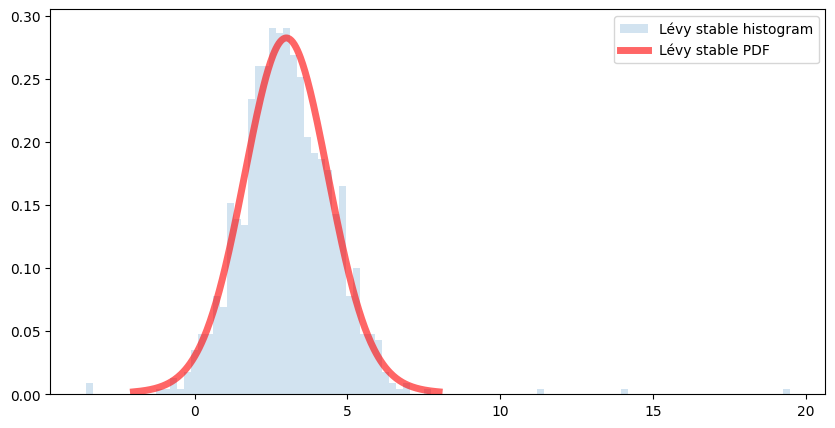

In [11]:
#Init parameters
sample_size = 1000
miu = 3.0
beta = 0
levy_exponent = 1.9
n_steps = 400
tail_limit = 5

aux_domain = np.linspace(miu - tail_limit, miu + tail_limit, n_steps)
levy_pdf = np.array([levy_stable.pdf(i, alpha=levy_exponent, beta=beta, loc=miu) for i in aux_domain])
random_levy = levy_stable.rvs(alpha=levy_exponent, beta=beta, loc=miu, size=sample_size)

fig, ax = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(10)

ax.hist(random_levy, bins=100, density=True, histtype="stepfilled", alpha=0.2, label="Lévy stable histogram")
ax.plot(aux_domain, levy_pdf, "r-", lw=5, alpha=0.6, label="Lévy stable PDF")
ax.legend(loc="best")
plt.show()

## Actividad 3: Lévy ﬂight - Vec2d - 1 Trajectory (6 pts)

* Utilizar **Vec2d**
* Guardar trayectorias en **Pandas** Data Frame
* Visualizar proyección en 3d con **plotly**

In [28]:
def generate_levy_flight(n_steps, speed, miu, beta, levy_exponent, cauchy_exponent, start_pos=[0,0]):
  """
  Returns a dataframe of a Levy Flight following a cauchy distribution for the
  turning angle and a levy stable distribution for the displacement
  """

  # Init velocity vector
  velocity = Vec2d(speed, 0)

  # Init Lévy Flight dataframe
  levy_df = pd.DataFrame(columns = ["x_pos", "y_pos"])
  temp_df = pd.DataFrame([{"x_pos":start_pos[0], "y_pos": start_pos[1]}])
  levy_df = pd.concat([levy_df, temp_df], ignore_index=True)

  # Init steps control variables
  levy_steps = 1
  step_count = 0

  for i in range(n_steps-1):
    if step_count >= levy_steps:
      # Define turn angle following a cauchy distribution
      turn_angle = wrapcauchy.rvs(cauchy_exponent)
      velocity = velocity.rotated(turn_angle)

      # Populate dataframe with walker displacement
      temp_df = pd.DataFrame([{"x_pos":levy_df.x_pos[i]+velocity.x, "y_pos": levy_df.y_pos[i]+velocity.y}])
      levy_df = pd.concat([levy_df, temp_df], ignore_index=True)

      # Reset steps control variables
      levy_steps = levy_stable.rvs(alpha=levy_exponent, beta=beta, loc=miu)
      step_count = 0
    else:
      # Increase a step without a change on direction
      step_count += 1
      temp_df = pd.DataFrame([{"x_pos":levy_df.x_pos[i]+velocity.x, "y_pos": levy_df.y_pos[i]+velocity.y}])
      levy_df = pd.concat([levy_df, temp_df], ignore_index=True)

  return levy_df

# Init parameters
n_steps = 100000
speed = 1
s_pos = 0
cauchy_exponent = 0.7
miu = 0.0
beta = 1.0
levy_exponent = 1.2

levy_df = generate_levy_flight(n_steps, speed, miu, beta, levy_exponent, cauchy_exponent)

fig_levy = PlotUtility("Levy Flight in 3D")
fig_levy.scatter_plot("Levy Flight 3D", levy_df.x_pos, levy_df.y_pos, levy_df.index)
fig_levy.show_plot("x_pos(mm)", "y_pos(mm)")

## Actividad 4: Correlated Random Walk - Vec2d - N Trajectories (7 pts)

* Generar tantas trayectorias tipo CRW como se especifique en una variable n_traj
* Cada una de las trayectorias debera tener un coeficiente de Cauchy diferente
* Utilizar **Vec2d**
* Guardar trayectorias en **Pandas** Data Frame
* Visualizar proyección en 3d con **plotly**
* Exportar trayectorias como *pkl*

In [15]:
def correlated_random_walker(n_steps, speed, cauchy_exponent, start_pos=[0,0]):
  """
  Returns a dataframe of a Correlated Random Walk following a cauchy
  distribution of cauchy_exponent with a given value of steps n_steps
  and speed that starts in position start_pos
  """

  # Init velocity vector
  velocity = Vec2d(speed, 0)

  # Init Correlated Random Walk dataframe
  CRW_2d_df = pd.DataFrame(columns = ["x_pos", "y_pos"])
  temp_df = pd.DataFrame([{"x_pos":start_pos[0], "y_pos": start_pos[1]}])
  CRW_2d_df = pd.concat([CRW_2d_df, temp_df], ignore_index=True)

  for i in range(n_steps-1):
    # Define turn angle following a cauchy distribution
    turn_angle = wrapcauchy.rvs(cauchy_exponent)
    velocity = velocity.rotated(turn_angle)
    # Populate dataframe with walker displacement
    temp_df = pd.DataFrame([{"x_pos":CRW_2d_df.x_pos[i]+velocity.x, "y_pos": CRW_2d_df.y_pos[i]+velocity.y}])
    CRW_2d_df = pd.concat([CRW_2d_df, temp_df], ignore_index=True)

  return CRW_2d_df

# Init parameters
n_steps = 1000
speed = 6
s_pos = [0,0]
n_traj = 6
pickle_df = pd.DataFrame()

cauchy_exponents = np.random.uniform(0, 1, n_traj)
aux_domain_CRW = np.linspace(0, 1, n_steps)
fig_CRW = PlotUtility("CRW of multiple trajectories")

for i, cauchy_exponent in enumerate(cauchy_exponents):
  rounded_cauchy = round(cauchy_exponent,3)

  CRW_df = correlated_random_walker(n_steps, speed, cauchy_exponent, s_pos)
  fig_CRW.scatter_plot(f"CRW with Cauchy {rounded_cauchy}", CRW_df.x_pos, CRW_df.y_pos, aux_domain_CRW)

  # Add columns to dataframe for later export to pickle file
  pickle_df.insert(i, f"x_CRW_{rounded_cauchy}", CRW_df.x_pos)
  pickle_df.insert(i+1, f"y_CRW_{rounded_cauchy}", CRW_df.y_pos)

fig_CRW.show_plot("x_pos(mm)", "y_pos(mm)", "time")

# Export to pkl file
pickle_df.to_pickle("./CRW_trajectories.pkl")
